# MODERN PORTFOLIO THEORY & CAPITAL ASSET PRICING MODEL

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
def get_return_series(ticker, start="2020-01-01", end=None, auto_adjust=False):
    """
    Download adjusted price data for a single ticker and return its daily return Series.
    """
    df = yf.download(ticker, start=start, end=end, auto_adjust=auto_adjust)
    if df.empty:
        raise ValueError(f"No data for {ticker} in {start}–{end}")
    prices = df["Adj Close"] if "Adj Close" in df.columns else df["Close"]
    ret = prices.pct_change().dropna()
    ret.name = ticker
    return ret

In [3]:
def build_returns_dict(tickers, start="2020-01-01", end=None, auto_adjust=False):
    """
    Returns a dict mapping ticker → dict with keys:
      - "returns": pd.Series of daily returns
      - "mean":    float mean(return)
      - "std":     float std(return)
    """
    R = {}
    for t in tickers:
        sr = get_return_series(t, start, end, auto_adjust)
        R[t] = {
            "returns": sr,
            "mean":    sr.mean(),
            "std":     sr.std(ddof=0)
        }
    return R

In [4]:
def compute_mean_vector(returns_dict):
    """
    From the returns_dict, build a pd.Series of means (the μ vector).
    """
    return pd.Series({t: info["mean"] for t, info in returns_dict.items()})

In [5]:
def compute_covariance_matrix(returns_dict):
    """
    Build the variance–covariance matrix Σ.
    Diagonal: Var(r_i),  Off‑diagonal: Cov(r_i, r_j).
    """
    # concat each returns Series into one DataFrame
    df = pd.concat([info["returns"] for info in returns_dict.values()], axis=1)
    df.columns = list(returns_dict.keys())
    return df.cov(ddof=0)


In [6]:
tickers = ["AAPL", "CAT", "JPM"]
Rdict = build_returns_dict(tickers,
                               start="2022-01-01",
                               end="2024-12-31",
                               auto_adjust=False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
# 1) Mean vector μ
mu = compute_mean_vector(Rdict)
print("Mean vector (μ):\n", mu.round(6), "\n")

# 2) Variance–Covariance matrix Σ
Sigma = compute_covariance_matrix(Rdict)
print("Covariance matrix (Σ):\n", Sigma.round(6), "\n")

Mean vector (μ):
 AAPL    Ticker
AAPL    0.000601
dtype: float64
CAT         Ticker
CAT    0.001
dtype: float64
JPM      Ticker
JPM    0.000758
dtype: float64
dtype: object 

Covariance matrix (Σ):
           AAPL       CAT       JPM
AAPL  0.000291  0.000095  0.000094
CAT   0.000095  0.000346  0.000148
JPM   0.000094  0.000148  0.000248 



## Checking results are correct:
Variance

In [8]:
for ticket in Rdict.keys():
      var = Rdict[ticket]["std"]**2
      print(f"{ticket} has a variance of {var}")


AAPL has a variance of Ticker
AAPL    0.000291
dtype: float64
CAT has a variance of Ticker
CAT    0.000346
dtype: float64
JPM has a variance of Ticker
JPM    0.000248
dtype: float64


Covariance

In [9]:
def manual_cov(series_x, series_y):
    """
    Compute population covariance manually between two aligned Series.
    """
    x = series_x.values
    y = series_y.values
    mu_x = np.mean(x)
    mu_y = np.mean(y)
    return np.mean((x - mu_x) * (y - mu_y))


In [10]:
# --- Using your setup ---
aaple_series = Rdict["AAPL"]["returns"]
cat_series = Rdict["CAT"]["returns"]
jpm_series = Rdict["JPM"]["returns"]


# Flatten to Series if needed
if isinstance(aaple_series, pd.DataFrame):
    aaple_series = aaple_series.squeeze()

if isinstance(cat_series, pd.DataFrame):
    cat_series = cat_series.squeeze()

# Align by index
aligned = pd.concat([aaple_series, cat_series], axis=1, join='inner')
aligned.columns = ['AAPL', 'CAT']

# Manual covariance
cov_manual = manual_cov(aligned['AAPL'], aligned['CAT'])
print("Manual Covariance (AAPL, CAT):", cov_manual)


Manual Covariance (AAPL, CAT): 9.539263590006611e-05


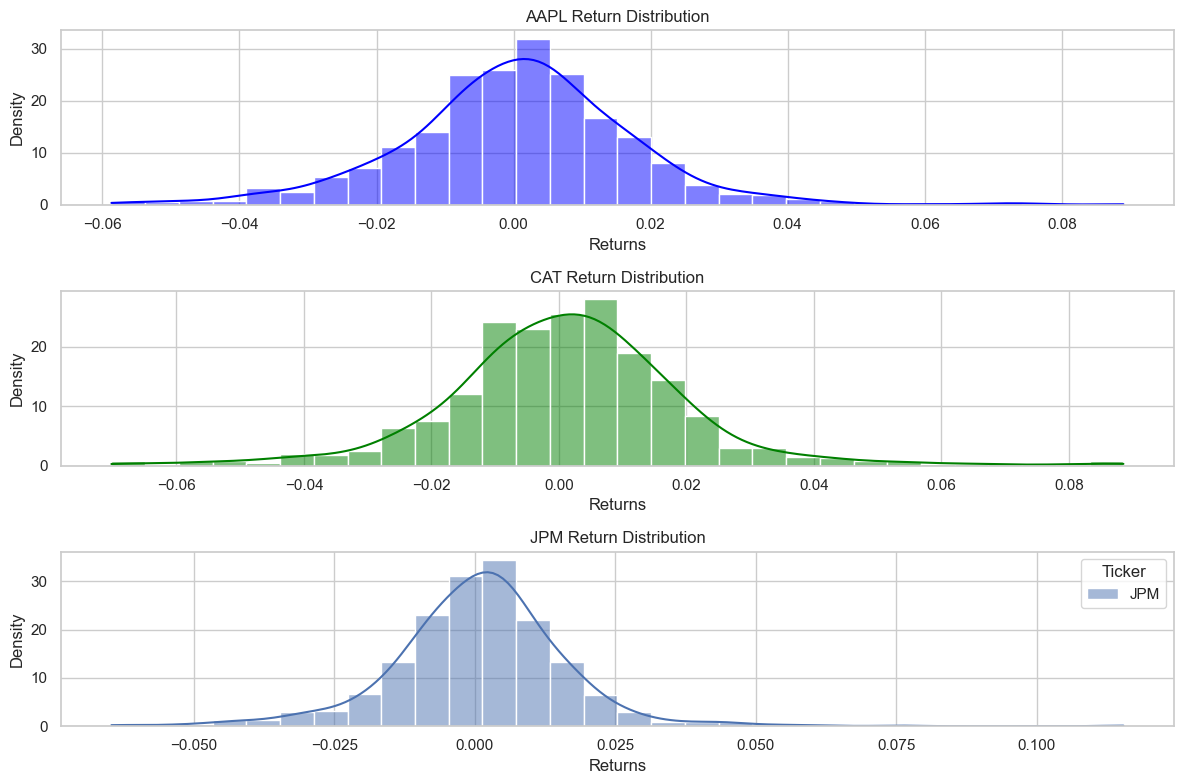

In [11]:

# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure for the distribution plots
plt.figure(figsize=(12, 8))

# Plot histogram and KDE for each stock's returns
plt.subplot(3, 1, 1)  # AAPL's returns
sns.histplot(aaple_series, kde=True, bins=30, color="blue", label="AAPL", stat="density")
plt.title("AAPL Return Distribution")
plt.xlabel("Returns")
plt.ylabel("Density")

plt.subplot(3, 1, 2)  # CAT's returns
sns.histplot(cat_series, kde=True, bins=30, color="green", label="CAT", stat="density")
plt.title("CAT Return Distribution")
plt.xlabel("Returns")
plt.ylabel("Density")

plt.subplot(3, 1, 3)  # JPM's returns
sns.histplot(jpm_series, kde=True, bins=30, color="red", label="JPM", stat="density")
plt.title("JPM Return Distribution")
plt.xlabel("Returns")
plt.ylabel("Density")

# Show the plots
plt.tight_layout()
plt.show()





<hr>

# 1) Getting Sigma and MU matrices

In [12]:
values = mu.apply(lambda x: x.values[0])  # Get the numeric value from each Series

In [13]:
MU = values.values.reshape(-1, 1)  # (n, 1)
MU

array([[0.00060132],
       [0.00100006],
       [0.00075759]])

In [14]:
SIGMA = Sigma.to_numpy()
SIGMA

array([[2.91214964e-04, 9.53926359e-05, 9.42886485e-05],
       [9.53926359e-05, 3.46481627e-04, 1.47781850e-04],
       [9.42886485e-05, 1.47781850e-04, 2.47841910e-04]])

In [15]:
SIGMA_INV = np.linalg.inv(SIGMA)
SIGMA_INV

array([[ 4009.53945664,  -607.89064647, -1162.91410093],
       [ -607.89064647,  3962.68540321, -2131.58377173],
       [-1162.91410093, -2131.58377173,  5748.25699536]])

In [16]:
MU_EXAMPLE = np.array([
      [.0427], 
      [.0015], 
      [.0285]
      ])

In [17]:
SIGMA_EXAMPLE = np.array([
      [.0100, .0018, .0011],
      [.0018, .0109, .0026],
      [.0011, .0026, .0199]
      ])
SIGMA_INV_EXAMPLE = np.linalg.inv(SIGMA_EXAMPLE)

In [18]:
W = np.array([[.2], [.3], [.5]])

In [19]:
expected_return = W.T @  MU    
expected_return 

array([[0.00079908]])

In [20]:
expected_variance = W.T @  SIGMA @ W     
expected_variance 

array([[0.00017943]])

# 2) Global Minimum Variance Portfolio

In [21]:
one_vec = np.ones((3,1))
W_mgvp =  (SIGMA_INV @ one_vec)/ (one_vec.T @ SIGMA_INV @ one_vec)
W_mgvp

array([[0.37843922],
       [0.2067735 ],
       [0.41478728]])

Lets verify all weight vectors add up to 1

In [22]:
W_mgvp.sum()

np.float64(1.0)

Lets check the variance and the expected excess return as a baseline.

In [23]:
expected_return_mgvp = W_mgvp.T @ MU
expected_return_mgvp

array([[0.00074859]])

In [24]:
expected_variance_mgvp = W_mgvp.T @ SIGMA @ W_mgvp
expected_variance_mgvp

array([[0.00016904]])

# 3) Efficient Portfolios
Note we do not restrict to long positions on the securities. We allow for shorting

In [25]:
A = one_vec.T @ SIGMA_INV @  one_vec
B = one_vec.T @ SIGMA_INV @ MU
C = MU.T @ SIGMA_INV @ MU
D = A * C - B**2

In [26]:
MU

array([[0.00060132],
       [0.00100006],
       [0.00075759]])

In [27]:
MU.min()


np.float64(0.0006013152833373819)

In [28]:
def _get_weights(Rp):
      weights = SIGMA_INV @ ((((A*Rp) - B)*MU + (C-B*Rp)*one_vec)/D)
      assert round(weights.sum(), 2) == 1, f"Weights must add up to 1. {weights.sum()}"
      return weights

def _get_variance(Rp):
      return (A * Rp**2 - 2*B*Rp + C) / D


In [32]:
def get_efficient_portfolios():
      """
      Returns corresponding weights and variance for the effiuceint protfolios
      """
      min_u = MU.min()
      max_u = MU.max()
      u_range = np.linspace(min_u, max_u, 100)
      weights = []
      variances = []
      sigmas = []
      expected_returns = []
      for u in u_range:
            weights.append(_get_weights(u))
            var = _get_variance(u)
            variances.append(var)
            sigmas.append(np.sqrt(var))
            expected_returns.append(u)
      return pd.DataFrame({"weights": weights, "variance": variances, "sigma":sigmas,"expected_return": expected_returns})

efficient_portfolios = get_efficient_portfolios()
efficient_portfolios

,weights,variance,sigma,expected_return
0,"[[0.6733289860143031], [-0.21055443665511103],...",[[0.00022665239560824176]],[[0.015054979096904843]],0.000601
1,"[[0.6652641192250235], [-0.19914103889313411],...",[[0.00022354431735515463]],[[0.014951398508338765]],0.000605
2,"[[0.6571992524357437], [-0.18772764113115678],...",[[0.00022052241962482595]],[[0.014849997293764936]],0.000609
3,"[[0.6491343856464638], [-0.1763142433691796], ...",[[0.0002175867024172559]],[[0.014750820398108572]],0.000613
4,"[[0.6410695188571838], [-0.1649008456072023], ...",[[0.00021473716573244464]],[[0.014653912983652]],0.000617
...,...,...,...,...
95,"[[-0.09283335896728037], [0.8737183507327214],...",[[0.00031618099568303396]],[[0.017781479007187056]],0.000984
96,"[[-0.10089822575655996], [0.8851317484946983],...",[[0.00032126006709203426]],[[0.017923729162538534]],0.000988
97,"[[-0.10896309254583908], [0.896545146256676], ...",[[0.00032642531902379277]],[[0.01806724436719094]],0.000992
98,"[[-0.11702795933511978], [0.9079585440186535],...",[[0.0003316767514783099]],[[0.018211994714426805]],0.000996


In [33]:
new_weights = efficient_portfolios.iloc[0]['weights']
new_weights.T @ MU

array([[0.00060132]])

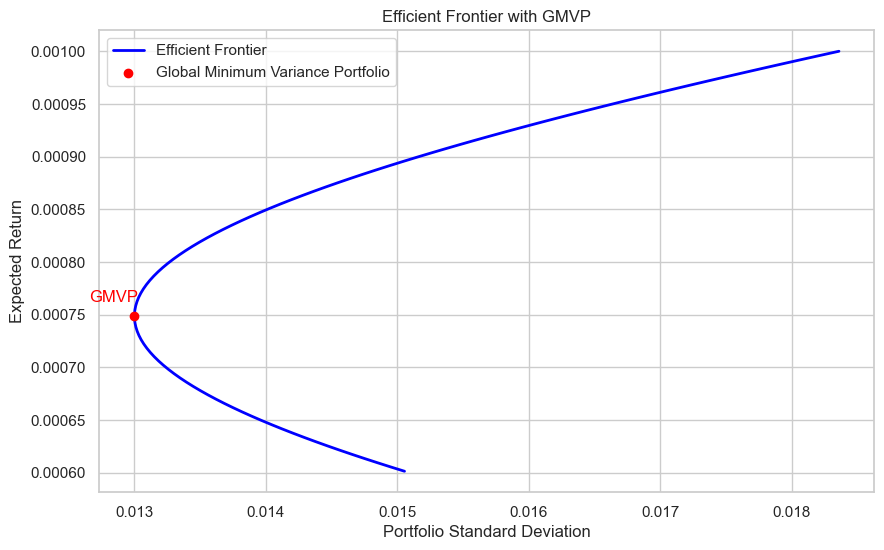

In [34]:
# Convert expected values to scalars if they're still 1x1 arrays
expected_variance_mgvp = float(expected_variance_mgvp)
expected_return_mgvp = float(expected_return_mgvp)

# Plot the efficient frontier (if not already plotted)
plt.figure(figsize=(10, 6))
plt.plot(
    (efficient_portfolios['sigma']),  # sqrt to convert to std dev if you want
    efficient_portfolios['expected_return'],
    label='Efficient Frontier',
    color='blue',
    lw=2
)

# Plot the GMVP
plt.scatter(
    np.sqrt(expected_variance_mgvp),  # Or expected_variance_mgvp if you're using variance
    expected_return_mgvp,
    color='red',
    label='Global Minimum Variance Portfolio',
    zorder=5
)

# Annotate the point
plt.annotate(
    'GMVP',
    (np.sqrt(expected_variance_mgvp), expected_return_mgvp),
    textcoords="offset points",
    xytext=(-15,10),
    ha='center',
    color='red'
)

plt.xlabel('Portfolio Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with GMVP')
plt.grid(True)
plt.legend()
plt.show()


# Capital Asset Pricing Model

In [35]:
rf = 0.0002

In [36]:
# 2. compute excess returns
excess = MU - rf * one_vec         # shape (n,1)

# 3. the un-normalized tangency weights
unnormalized = SIGMA_INV @ excess  # shape (n,1)

# 4. normalization constant so weights sum to 1
norm = float(one_vec.T @ unnormalized)

# 5. the Maximum Sharpe‐Ratio portfolio weights
w_msr = unnormalized / norm 
w_msr

/var/folders/wl/wsfchl5x6mncflznhbn2q1gc0000gn/T/ipykernel_23630/3494881120.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  norm = float(one_vec.T @ unnormalized)


array([[0.14615234],
       [0.53550584],
       [0.31834182]])

In [37]:
w_msr.sum()

np.float64(1.0)

In [38]:
ret_msr = float(w_msr.T @ MU)
var_msr = float(w_msr.T @ SIGMA @ w_msr)
sharpe_msr = (ret_msr - rf) / np.sqrt(var_msr)
std_msr = np.sqrt(var_msr)

/var/folders/wl/wsfchl5x6mncflznhbn2q1gc0000gn/T/ipykernel_23630/658073722.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ret_msr = float(w_msr.T @ MU)
/var/folders/wl/wsfchl5x6mncflznhbn2q1gc0000gn/T/ipykernel_23630/658073722.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var_msr = float(w_msr.T @ SIGMA @ w_msr)


Now that we have the tangency portfolio we only need to compute the capital allocation line (CAL) / capital market line (CML) by altering from 1 to 1.5 alpha.

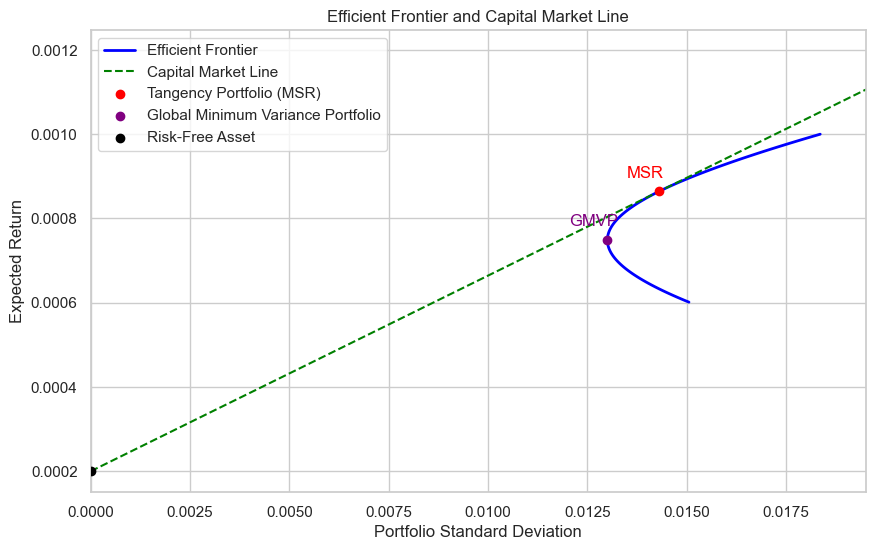

In [41]:
# Generate x-values (standard deviation) from 0 (rf-only) to std_msr * 1.5 (or more if desired)
std_range = np.linspace(0, std_msr * 1.5, 100)

# Compute corresponding returns on the CML
cml_returns = rf + ((ret_msr - rf) / std_msr) * std_range

# Plot the efficient frontier (already computed earlier)
plt.figure(figsize=(10, 6))
plt.plot((efficient_portfolios['sigma']), efficient_portfolios['expected_return'],
         label='Efficient Frontier', color='blue', lw=2)

# Plot the CML
plt.plot(std_range, cml_returns, color='green', linestyle='--', label='Capital Market Line')

# Plot the max Sharpe (tangency) portfolio
plt.scatter(std_msr, ret_msr, color='red', label='Tangency Portfolio (MSR)', zorder=5)
plt.annotate('MSR', (std_msr, ret_msr), textcoords="offset points", xytext=(-10,10), ha='center', color='red')

# Plot the globla minimum variance portfolio
plt.scatter(np.sqrt(expected_variance_mgvp), expected_return_mgvp, color='purple', label='Global Minimum Variance Portfolio', zorder=5)
plt.annotate('GMVP', (np.sqrt(expected_variance_mgvp), expected_return_mgvp), textcoords="offset points", xytext=(-10,10), ha='center', color='purple')

# Risk-free point
plt.scatter(0, rf, color='black', label='Risk-Free Asset', zorder=5)

plt.xlabel('Portfolio Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier and Capital Market Line')
plt.grid(True)
plt.xlim(0, np.sqrt(expected_variance_mgvp) * 1.5)
plt.legend()
plt.show()
